# Example 2

## 3D case

**Content**

This notebook reproduces the first example of the paper. It consists of four main subheadings;

- Importing the *hcpinnseikonal* package functions
- Define the arguments for the input parameters
- Setup the medium and compute the data
- Training and inference

**Saving directory**

The notebook utilized [*wandb*](https://wandb.ai) for keeping track of the parameters and experiments. You can uncomment the *wandb* call to turn this feature off. Accordingly you need to specify the folder to save your experiment by changing the related *wandb* line inside the main function below.

## What do I do?

I want to check whether embedding the latent space as an additionla neurons to the input (altogether), say 96 latent vector will add 96 neurons more to the input of the PINNs. 

The velocity is still being input as a pair as opposed to using the trained decoeder (from AE).

The training dynamic is still not random with regards to the velocity distribution, one velocity per 1k epochs.

PID: 44523

## Import *hcpinnseikonal* package functions

In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from argparse import ArgumentParser   
from scipy import interpolate
from scipy.ndimage import gaussian_filter

from hcpinnseikonal.utils import *
from hcpinnseikonal.model import *
from hcpinnseikonal.train3dwell import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='y'

args.project_name='HCPINNsEikonal3D-01-lvl-inversion'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_aridLVL3dwellelu'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriza

wandb: Currently logged in as: hatsyim. Use `wandb login --relogin` to force relogin


## Define arguments

In [2]:
args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=1000
args.seed=1234 
args.learning_rate=5e-4
args.rescale_plot='n' 
args.initial_velocity=3 
args.zid_source=1 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=12 
args.model_type='arid' 
args.v_multiplier=4
args.factorization_type='additive' 
args.tau_act='tanh' 
args.tau_multiplier=1 
args.max_offset=4.9875
args.max_depth=1.2287198 #1.865625 
args.vertical_spacing=0.0159574 #0.009375 
args.lateral_spacing=0.07556818 #0.0375
args.num_neurons=24 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=50 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.2 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=10 
args.sou_spacing=20

args.sampling_rate=6
args.well_spacing = 20

# args.num_layers=24
# args.num_neurons=48

dict_args=vars(args)
print(dict_args)

{'lateral_spacing': 0.07556818, 'vertical_spacing': 0.0159574, 'max_offset': 4.9875, 'max_depth': 1.2287198, 'rec_spacing': 10, 'sou_spacing': 20, 'num_epochs': 1000, 'num_neurons': 24, 'num_layers': 12, 'learning_rate': 0.0005, 'model_type': 'arid', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'y', 'earth_scale': 'n', 'scale_factor': 2, 'reduce_after': 50, 'seed': 1234, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 1, 'initial_velocity': 3, 'zid_source': 1, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 4, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'y', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 0.2, 'event_factor': 0.9, 'checker_size': 5.0, 'tau_act': 'tanh', 'empty_midd

## Operator Function

In [3]:
class VelocityNetwork(torch.nn.Module):
    def __init__(self, base_model, v_well=1, X_well=None):
        
            super(VelocityNetwork, self).__init__()
            
            self.model = base_model
            self.v_well = v_well
            self.X_well = X_well
            
            if self.X_well is not None:
                self.x_well = X_well[:,0]
                self.y_well = X_well[:,1]
            
    def _well_operator(self, x):
        x_op, y_op = 1, 1
        
        for i in range(len(self.x_well)):
            x_op *= abs(x[:,0].view(-1,1) - self.x_well[i]) 
        for i in range(len(self.y_well)):
            y_op *= abs(x[:,1].view(-1,1) - self.y_well[i])
        
        # return nn.Tanh()((x_op + y_op)).view(-1,1)

        # return torch.exp(-0.05*x[:,2]).view(-1,1)
        
        return (1-torch.exp(-5e-2*(x_op + y_op)))
        

    def forward(self,x,v_well=1):
        
        if self.X_well is not None:
            x = v_well.view(-1,1) + self.model(x) * self._well_operator(x)
        else:
            x = self.model(x)
        return x

## Medium setup and data interpolation

Cuda installed! Running on GPU!
Device: cuda:0 Tesla V100-SXM2-32GB
Loading time: 2.07 minutes


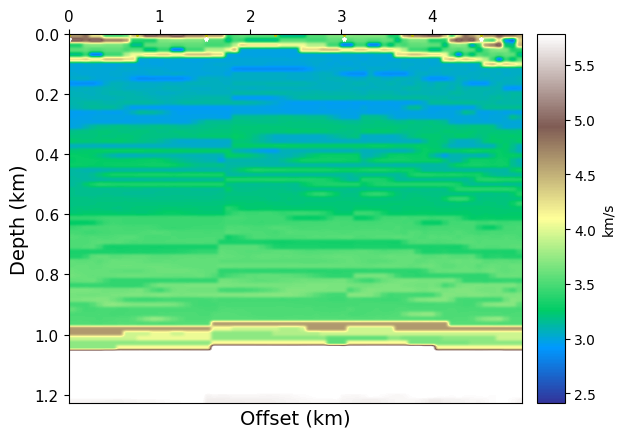

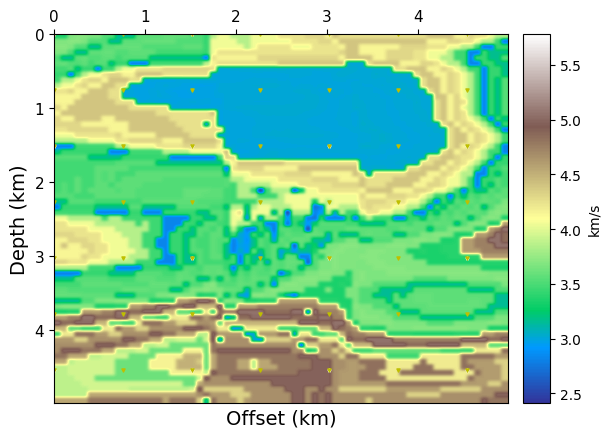

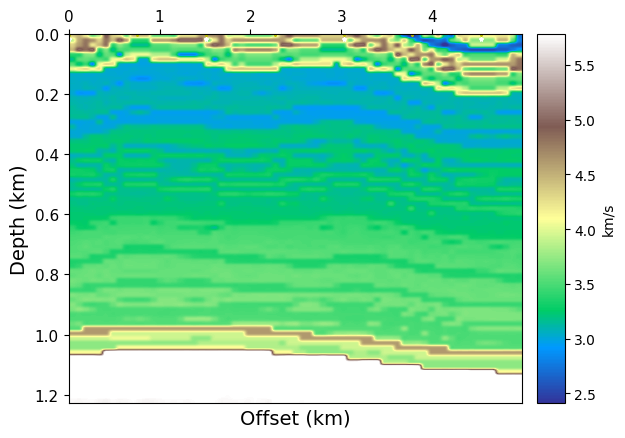

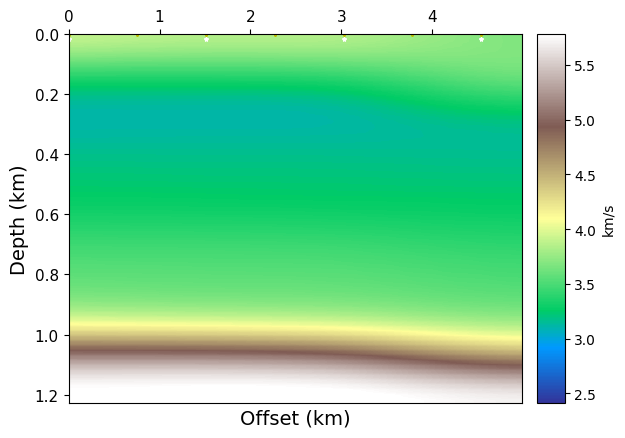

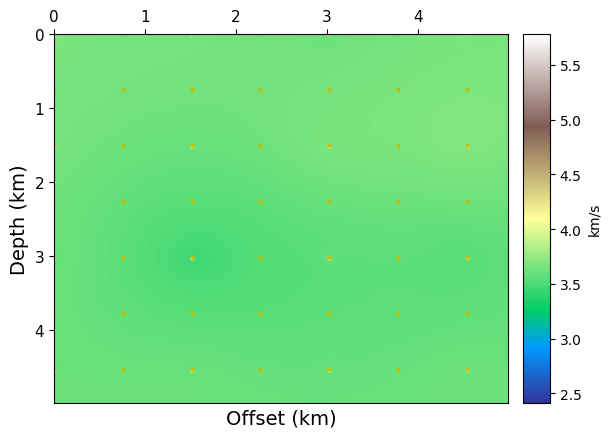

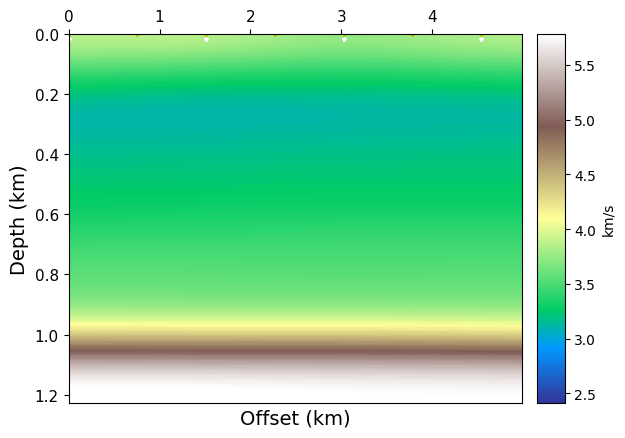

In [4]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Medium
data_type = args.data_type
deltar = args.rec_spacing
deltas = args.sou_spacing

# Computational model parameters
zmin = -0.1 if args.field_synthetic=='y' else 0; zmax = args.max_depth; deltaz = args.vertical_spacing;
ymin = 0.; ymax = args.max_offset; deltay = args.lateral_spacing;
xmin = 0.; xmax = args.max_offset; deltax = args.lateral_spacing;
# deltax, deltay, deltaz = args.sampling_rate*0.00625/2*4, args.sampling_rate*0.00625/2*4, args.sampling_rate*0.00625/2

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    ymin, ymax, deltay = earth_radi*ymin, earth_radi*ymax, earth_radi*deltay
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
z = np.arange(zmin,zmax,deltaz)
nz = z.size

y = np.arange(ymin,ymax,deltay)
ny = y.size

x = np.arange(xmin,xmax,deltax)
nx = x.size

Z,Y,X = np.meshgrid(z,y,x,indexing='ij')

# Number of training points
num_tr_pts = 4000 #int(args.num_points * nz * nx)

if args.field_synthetic=='y':
    import pandas as pd
    import pygmt
    import numpy as np

    import pandas as pd

    # Earthquake events location
    location = pd.read_csv('/home/taufikmh/KAUST/fall_2022/GFATT_PINNs/data/fang_etal_2020/sjfzcatlog.csv')

    # Recorded traveltime data
    traveltime = pd.read_table('/home/taufikmh/KAUST/fall_2022/GFATT_PINNs/data/fang_etal_2020/sjfz_traveltime.dat', delim_whitespace='y')

    # Rounding to make the coordinates rounding the same
    location, traveltime = location.round(3), traveltime.round(3)

    # Merge
    data = pd.merge(traveltime, location,  how='left', left_on=['evlat','evlon','evdep'], right_on = ['evlat','evlon','evdep'])

    # Create earthquake group
    data['event_id'] = data.groupby(['evlat', 'evlon', 'evdep']).cumcount() + 1
    data['station_id'] = data.groupby(['stlat', 'stlon', 'stele']).cumcount() + 1

    # Station only
    sta_only = data.drop_duplicates(subset=['stlat', 'stlon'], keep='last')

    # Event only
    eve_only = data.drop_duplicates(subset=['evlat', 'evlon'], keep='last')

    region = [-118, -115, 32.5, 34.50]
    x0,x1,y0,y1 = -117.45, -115.55, 34.15, 32.76

    # eve_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(eve_only.event_id.values), y0*np.ones_like(eve_only.event_id.values)])
    p2=np.array([(360+x1)*np.ones_like(eve_only.event_id.values), y1*np.ones_like(eve_only.event_id.values)])
    p3=np.array([eve_only.evlon, eve_only.evlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    eve_only.loc[:, 'closest_event'] = np.copy(d[0].values)

    # sta_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(sta_only.station_id.values), y0*np.ones_like(sta_only.station_id.values)])
    p2=np.array([(360+x1)*np.ones_like(sta_only.station_id.values), y1*np.ones_like(sta_only.station_id.values)])
    p3=np.array([sta_only.stlon, sta_only.stlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    sta_only.loc[:, 'closest_station'] = np.copy(d[0].values)

    closest_sta = sta_only[np.abs(sta_only['closest_station'])<0.003]
    closest_eve = eve_only[np.abs(eve_only['closest_event'])<0.00003]

    grid = pygmt.datasets.load_earth_relief(resolution="03m", region=region)

    points = pd.DataFrame(
        data=np.linspace(start=(x0, y0), stop=(x1, y1), num=len(x)),
        columns=["x", "y"],
    )

    track = pygmt.grdtrack(points=points, grid=grid, newcolname="elevation")
    xtop = track.x.values + 360
    ztop = track.elevation.values*1e-3

    xsta = closest_sta.stlon.values
    zsta = closest_sta.stele.values

    xeve = closest_eve.evlon.values
    zeve = closest_eve.evdep.values

    xtop,xsta,xeve = xtop-xtop.min(),xsta-xsta.min(),xeve-xeve.min()
    xtop,xsta,xeve = xtop/xtop.max()*xmax,xsta/xsta.max()*xmax,xeve/xeve.max()*xmax
    
    ytop,ysta,yeve = ytop-ytop.min(),ysta-ysta.min(),yeve-yeve.min()
    ytop,ysta,yeve = ytop/ytop.max()*ymax,ysta/ysta.max()*ymax,yeve/yeve.max()*ymax

    ztop,zsta,zeve = ztop-ztop.min(),zsta-zsta.min(),zeve-zeve.min()
    ztop,zsta,zeve = args.station_factor*ztop/ztop.max()+zmin,args.station_factor*zsta/zsta.max()+zmin,zmax-args.event_factor*zeve/zeve.max()

    xsta,xeve = xsta[(xsta>xtop.min()) & (xsta<xtop.max())], xeve[(xeve>xtop.min()) & (xeve<xtop.max())]
    ysta,yeve = ysta[(ysta>ytop.min()) & (ysta<ytop.max())], yeve[(yeve>ytop.min()) & (yeve<ytop.max())]
    zsta,zeve = zsta[(xsta>xtop.min()) & (xsta<xtop.max())],zeve[(xeve>xtop.min()) & (xeve<xtop.max())]

    if args.exclude_topo=='y':
        ztop, zsta = zmin*np.ones_like(ztop), zmin*np.ones_like(zsta)

    ztop, zsta = zmin-ztop, zmin-zsta

    id_sou_z = np.array([]).astype(int)

    for szi in zeve.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_sou_z = np.append(id_sou_z,sid)

    id_rec_z = np.array([]).astype(int)

    for rzi in zsta.round(2):
        sid = np.where(np.abs(z.round(3)-rzi)<1e-6)
        id_rec_z = np.append(id_rec_z,sid)

    id_sou_y = np.array([]).astype(int)

    for syi in yeve.round(2):
        sid = np.where(np.abs(y.round(3)-syi)<1.5e-2)
        id_sou_y = np.append(id_sou_y,sid)

    id_rec_y = np.array([]).astype(int)

    for ryi in ysta.round(2):
        sid = np.where(np.abs(y.round(3)-ryi)<1.5e-2)
        id_rec_y = np.append(id_rec_y,sid)
        
    id_sou_x = np.array([]).astype(int)

    for sxi in xeve.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1.5e-2)
        id_sou_x = np.append(id_sou_x,sid)

    id_rec_x = np.array([]).astype(int)

    for rxi in xsta.round(2):
        sid = np.where(np.abs(x.round(3)-rxi)<1.5e-2)
        id_rec_x = np.append(id_rec_x,sid)

    id_top_x = []
    id_top_y = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)
                
        for i in range(len(y)):
            if np.abs(ytop[h]-y[i])<1e-2:
                id_top_y.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    if args.regular_station=='y':
        id_rec_x = id_top_x[::args.rec_spacing]
        id_rec_y = id_top_y[::args.rec_spacing]
        id_rec_z = id_top_z[::args.rec_spacing]

    if args.append_shot=='y':
        for i in range(8):
            id_sou_x = np.append(id_sou_x, len(x)-1-2*i)
            id_sou_y = np.append(id_sou_y, len(y)-1-2*i)
            id_sou_z = np.append(id_sou_z, len(z)-1-int(0.5*i))
            
    # plt.plot(args.plotting_factor*(xtop-xtop.min()), args.plotting_factor*ztop)
    # plt.scatter(args.plotting_factor*(xeve-xtop.min()), args.plotting_factor*zeve)
    # plt.scatter(x[id_rec_x], z[id_rec_z], c='y', marker='v')
    # plt.title('Cross-section')
    # plt.xlabel('X (km)')
    # plt.ylabel('Z (km)')
    # plt.gca().invert_yaxis()
    # plt.axis('tight')
    # plt.savefig(os.path.join(wandb_dir, 'cross_section.pdf'), format='pdf', bbox_inches="tight")
else:
    zeve, yeve, xeve = z[args.zid_source]*np.ones_like(x[::deltas]), y[::deltas], x[::deltas]
    zsta, ysta, xsta = z[args.zid_receiver]*np.ones_like(x[::deltar]), y[::deltar], x[::deltar]
    ztop, ytop, xtop = zmin*np.ones_like(x), np.copy(y), np.copy(x)

    idx_all = np.arange(X.size).reshape(X.shape)
    
    # Sources indices
    id_sou = idx_all[args.zid_source, ::deltas, ::deltas].reshape(-1)
    
    # Receivers indices
    id_rec = idx_all[args.zid_receiver, ::deltar, ::deltar].reshape(-1)

# Keeping the number of shots fixed while centering the shots location
if args.middle_shot=='y':
    id_sou_left = x.shape[0]//2-len(id_sou_x)//2
    id_sou_x = np.array(range(id_sou_left, id_sou_left+len(id_sou_x)))
    id_sou_y = np.array(range(id_sou_left, id_sou_left+len(id_sou_y)))

if args.explode_reflector=='y':
    id_sou_x = np.arange(0, len(x), args.sou_spacing)
    id_sou_y = np.arange(0, len(y), args.sou_spacing)
    id_sou_z = np.ones_like(id_sou_x)*(len(z)-1)

if args.empty_middle=='y':
    id_sou, id_rec = (np.array(id_sou_x)<=(len(x)//2-50))|(np.array(id_sou_x)>=(len(x)//2+50)), (np.array(id_rec_x)<=(len(x)//2-50))|(np.array(id_rec_x)>=(len(x)//2+50))
    if args.field_synthetic=='n':
        id_sou_x = np.array(id_sou_x)[id_sou]
        id_sou_y = np.array(id_sou_y)[id_sou]
        id_sou_z = np.array(id_sou_z)[id_sou]
    id_rec_x = np.array(id_rec_x)[id_rec]
    id_rec_y = np.array(id_rec_y)[id_rec]
    id_rec_z = np.array(id_rec_z)[id_rec]

sz = Z.reshape(-1)[id_sou]
sy = Y.reshape(-1)[id_sou]
sx = X.reshape(-1)[id_sou]

Z,Y,X,SX = np.meshgrid(z,y,x,sx,indexing='ij')
_,_,_,SY = np.meshgrid(z,y,x,sy,indexing='ij')
_,_,_,SZ = np.meshgrid(z,y,x,sz,indexing='ij')
_,_,_,ID = np.meshgrid(z,y,x,np.arange(sx.size),indexing='ij')

## Sources location checkpointing
# for i in range(len(id_sou)):
#     print(np.unique(SX[:,:,:,i]), np.unique(SY[:,:,:,i]), np.unique(SZ[:,:,:,i]))

if args.model_type=='marmousi':
    vel = np.fromfile('../data/marmousi.bin', np.float32).reshape(221, 601)
    x1 = np.linspace(0, 5, 601)
    z1 = np.linspace(0, 1, 221) 
    x2 = np.linspace(0.25, 5, len(x))
    z2 = np.linspace(0.09, 0.55, len(z)) 
    f = interpolate.interp2d(x1, z1, vel, kind='cubic')
    vel = f(x2, z2)
    # Augment a 3D velocity volume from 2D data
    vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)
elif args.model_type=='seam':
    vel = np.load('/home/taufikmh/KAUST/spring_2022/constrained_eikonal/notebooks/PINNtomo/inputs/seam_model/vel_seam.npy')
    x1 = np.arange(0,1+0.01,0.01)
    z1 = np.arange(0,1+0.01,0.01)
    from scipy import interpolate
    f = interpolate.interp2d(x1, z1, vel, kind='cubic')
    vel = f(x, z)
    # Augment a 3D velocity volume from 2D data
    vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)
elif args.model_type=='constant':
    vel = 4*np.ones((nz,nx))
elif args.model_type=='gradient':
    vel = 1 + 7*np.meshgrid(x,z)[1]
elif args.model_type=='arid':
    vel = np.fromfile('../data/seam_arid', np.float32).reshape(400,400,600)/1000
    vel3d = np.moveaxis(vel[::args.sampling_rate,::args.sampling_rate,::args.sampling_rate], -1, 0)[5:82,:,:]
    
# Extending the velocity model in thirs dimension byy repeatin the array
velmodel = np.repeat(vel3d[...,np.newaxis], sx.size,axis=2)

if args.depth_shift=='y':
    zmin, zmax, z, sz, Z, SZ = zmin+5, zmax+5, z+5, sz+5, Z+5, SZ+5

X_star = [Z.reshape(-1,1), Y.reshape(-1,1), X.reshape(-1,1), SY.reshape(-1,1), SX.reshape(-1,1)] # Grid points for prediction 

# Numerical traveltime
T_data3d = numerical_traveltime3d(vel3d, len(x), len(y), len(z), len(id_sou), 
                                  xmin, ymin, zmin, deltax, deltay, deltaz, 
                                  [np.where(x==X[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(y==Y[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(z==Z[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))])

# ZX plane after
plot_section(vel3d[:,10,:], 'v_data_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# XY plane
plot_section(vel3d[5,:,:], 'v_data_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Y[:,:,:,0].reshape(-1)[id_rec])

# ZY plane
plot_section(vel3d[:,:,10], 'v_data_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=Y[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# Plots
if args.model_type=='checkerboard':
    plot_section((6 + 6.5217391304347826*Z[:,:,0])/args.scale_factor, "v_back.pdf", 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])
    plot_section(velpert[:,:,0]/args.scale_factor, "v_pert.pdf", 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

# Interpolation
Td_nn = np.zeros_like(T_data3d)
taudx_nn = np.zeros_like(T_data3d)

Ti_data = np.zeros((len(id_rec)*len(id_sou)))
xri = np.tile(X.reshape(-1)[id_rec], len(id_sou))
yri = np.tile(Y.reshape(-1)[id_rec], len(id_sou))
zri = np.tile(Z.reshape(-1)[id_rec], len(id_sou))

xsi = np.repeat(X.reshape(-1)[id_sou], len(id_rec))
ysi = np.repeat(Y.reshape(-1)[id_sou], len(id_rec))
zsi = np.repeat(Z.reshape(-1)[id_sou], len(id_rec))

for i in range(len(id_sou)):
    Ti_data[i*len(id_rec):(i+1)*len(id_rec)] = T_data3d[:,:,:,i].reshape(-1)[id_rec]
    
rand_idx = np.random.permutation(np.arange(len(Ti_data)))

X_ori = np.vstack((xri, yri, zri, xsi, ysi, zsi)).T
y_ori = Ti_data

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

if data_type=='nn':
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(6, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(5e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn = np.zeros_like(T_data3d)
    
    if args.field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx)), 
                 np.tile(y, len(sy)),
                 np.tile(z[args.zid_receiver]*np.ones_like(x), len(sz)), 
                 np.repeat(x[id_sou_x], len(x)), 
                 np.repeat(y[id_sou_y], len(y)), 
                 np.repeat(z[id_sou_z], len(z))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou)):
        Td_nn[:,:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join(wandb_dir, "data_loss.pdf"), format='pdf', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, wandb_dir+'/saved_data_model')

# Analytical solution for the known traveltime part
if args.depth_shift=='y':
    vs = args.initial_velocity #velmodel[np.round((SZ-5)/deltaz).astype(int),np.round(SX/deltax).astype(int),0]
else:
    vs = vel3d[np.round(SZ/deltaz).astype(int),np.round(SY/deltay).astype(int),np.round(SX/deltax).astype(int)]

T0 = np.sqrt((Z-SZ)**2 + (Y-SY)**2 + (X-SX)**2)/vs;
px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
py0 = np.divide(Y-SY, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

if args.field_synthetic=='y':
    xf = np.arange(xmin,xmax+0.1*deltax,0.1*deltax)
    zf = np.arange(zmin,zmax+0.1*deltaz,0.1*deltaz)
    T_topo = np.zeros((len(zf), len(xf), len(id_sou_x)))
    for i in range(len(id_sou_x)):
        f = interpolate.interp2d(x, z, T_data3d[:,:,i], kind='cubic')
        T_topo[:,:,i] = f(xf, zf)
    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    taud_topo = np.divide(T_data3d, T0, where=T0!=0)[id_top_z, id_top_x, :]
    T_topo = T_data[id_top_z, id_top_x, :]

    taud_topo = np.repeat(taud_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)
    T_topo = np.repeat(T_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)

Td_hc = np.zeros_like(T0)
T0_hc = np.zeros_like(T0)
taud_hc = np.zeros_like(T0)
taudx_hc = np.zeros_like(T0)
taudy_hc = np.zeros_like(T0)

for i in range(len(id_sou)):
    T0_hc[:,:,:,i] = np.moveaxis(np.tile(T0.reshape(X.shape)[args.zid_receiver,:,:,i], nz).reshape(ny,nz,nx), 1, 0)
    # np.tile(T0[args.zid_receiver,:,:,i], nz).reshape(nz,ny,nx)

    # Numerical
    if data_type=='full':
        Td_hc[:,:,:,i] = np.moveaxis(np.tile(T_data3d[args.zid_receiver,:,:,i], nz).reshape(ny,nz,nx), 1, 0)
    # np.tile(T_data3d[args.zid_receiver,:,:,i], nz).reshape(nz,ny,nx)

    # NN-based interpolation
    elif data_type=='nn':
        Td_hc[:,:,:,i] = Td_nn[:,:,:,i].reshape(nz,ny,nx)

    if args.factorization_type=='multiplicative':   
        taud_hc[:,:,:,i] = np.divide(Td_hc[:,:,:,i], T0_hc[:,:,:,i], out=np.ones_like(T0_hc[:,:,:,i]),
                                   where=T0_hc[:,:,:,i]!=0)
    else:
        taud_hc[:,:,:,i] = Td_hc[:,:,:,i] - T0_hc[:,:,:,i]

    # Numerical
    if data_type=='full':
        taudy_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltay, axis=1)
        taudx_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltax, axis=2)

    # NN-based interpolation
    elif data_type=='nn':
        taudy_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltay, axis=1)        
        taudx_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltax, axis=2)

if args.field_synthetic=='y':

    NAN = np.ones_like(X)
    for i in range(z.shape[0]):
        for j in range(x.shape[0]):
            if z[i] < Z[id_top_z, id_top_x, 0][j]:
                NAN[i,j,:] = float("Nan")
                
# # Interpolation check            
# plot_int = len(id_sou)//5 if len(id_sou)>=5 else 1
# for i in range(0, len(id_sou), plot_int):
#     plt.figure()
#     plt.scatter(x[id_rec_x], T_data[id_rec_z,id_rec_x,i], label='Data')
#     plt.scatter(x[id_rec_x], Td_hc[id_rec_z,id_rec_x,i], label='Interpolated')
#     plt.legend(['Data', 'Interpolation'])
#     plt.savefig(os.path.join(wandb_dir, "interpolation.pdf"), format='pdf', bbox_inches="tight")

# Locate source boolean
import time
start_time = time.time()

sids = id_sou

# Locate source boolean
isource = np.ones_like(Z).astype(bool)

# Locate source boolean
for i in range(isource.shape[-1]):
    isource[:,:,:,i].reshape(-1,)[id_sou[i]] = False
    
isource = isource.reshape(-1)

velmodel = vel3d.reshape(-1,1)
px0 = px0.reshape(-1,1)
py0 = py0.reshape(-1,1)
pz0 = pz0.reshape(-1,1)
T0 = T0.reshape(-1,1)
T_data = T_data3d.reshape(-1,1)
taud = taud_hc.reshape(-1,1)

v_well = gaussian_filter(
    perform_kriging(vel3d.reshape(Z[:,:,:,0].shape), X[:,:,:,0], Y[:,:,:,0], args.well_spacing), 
    sigma=[5,1,1]
)

if args.factorization_type=='multiplicative':
    taud[~isource] = 1.    
taudx = taudx_hc.reshape(-1,1)
taudy = taudy_hc.reshape(-1,1)
index = ID.reshape(-1,1)

perm_id = np.random.permutation(X.size-sx.size)

input_wsrc = [X, Y, Z, SX, SY, SZ, taud, taudx, taudy, T0, px0, py0, pz0, index,  np.repeat(v_well[...,np.newaxis], sx.size,axis=2).reshape(-1,1)]
input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]
if args.field_synthetic=='y':
    input_wonan = [i.ravel()[~np.isnan(NAN.ravel()[isource.reshape(-1)][perm_id])] for i in input_wosrc]

# Network
lay = 'linear'
ini = args.initialization
bias = 0.02
mean = 0.001
std = 0.005
opttype = 'adam'
lr = args.learning_rate

torch.manual_seed(seed)
if args.residual_network=='n':
    tau_model = FullyConnectedNetwork(4, 1, [args.num_neurons]*args.num_layers, last_act=args.tau_act, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
else:
    tau_model = ResidualNetwork(6, 1, num_neurons=args.num_neurons, num_layers=args.num_layers, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
tau_model.to(device)

torch.manual_seed(seed)
if args.residual_network=='n':
    base_model = FullyConnectedNetwork(3, 1, [args.num_neurons//2]*args.num_layers, act=args.activation, lay=lay, last_act='relu', last_multiplier=args.v_multiplier)
else:
    base_model = ResidualNetwork(3, 1, num_neurons=args.num_neurons//2, act='relu', last_act='elu', num_layers=args.num_layers, lay=lay, last_multiplier=args.v_multiplier)
base_model.to(device)
base_model.apply(lambda m: init_weights(m, init_type=ini, bias=bias, mean=mean, std=std))

X_well = np.hstack(
    (X[0,::args.well_spacing,::args.well_spacing, 0].reshape(-1,1), 
    Y[0,::args.well_spacing,::args.well_spacing, 0].reshape(-1,1))
)

v_well = torch.from_numpy(v_well).to(device)

v_model = VelocityNetwork(base_model, v_well, X_well)
v_model.to(device)

perc = args.num_points

if args.irregular_grid=='y':
    npoints = int(X.size * perc)
    ipermute = np.random.permutation(np.arange(X.size))[:npoints]
else:
    ipermute = None

# Compute traveltime with randomly initialized network
pde_loader, ic = create_dataloader3dwell([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048, fast_loader=True, perm_id=ipermute)

if args.exp_function=='y':
    rec_op = (1-np.exp((Z.reshape(X.shape)-z[args.zid_receiver])**args.exp_factor))
else:
    rec_op = Z.reshape(X.shape)

# if args.factorization_type=='multiplicative':
#     tau_true = np.divide(
#         T_data.reshape(X.shape), 
#         T0.reshape(X.shape), 
#         out=np.ones_like(T0.reshape(X.shape)), 
#         where=T0.reshape(X.shape)!=0
#     )
#     tau_true = tau_true - taud.reshape(X.shape)
#     tau_true = np.divide(
#         tau_true, 
#         rec_op, 
#         out=np.ones_like(Z.reshape(X.shape)), 
#         where=Z.reshape(X.shape)!=0
#     )
#     T_true = (rec_op*tau_true + taud.reshape(X.shape))*T0.reshape(X.shape)
# else:
#     tau_true = T_data.reshape(X.shape) - T0.reshape(X.shape) - taud.reshape(X.shape)
#     tau_true = np.divide(
#         tau_true, 
#         rec_op, 
#         out=np.ones_like(Z.reshape(X.shape)), 
#         where=Z.reshape(X.shape)!=0
#     )
#     T_true = rec_op*tau_true + taud.reshape(X.shape) + T0.reshape(X.shape)

v_init = evaluate_velocity3d(v_model, pde_loader, X.size, batch_size=2048, device=device)
tau_init = evaluate_tau3d(tau_model, pde_loader, X.size, batch_size=2048, device=device)

elapsed = time.time() - start_time
print('Loading time: %.2f minutes' %(elapsed/60.))

# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(list(tau_model.parameters()) + list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()) + list(v_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=args.reduce_after, verbose=True)

v_init = v_init.detach().cpu().numpy().reshape(X.shape)

# ZX plane after
plot_section(v_well.cpu().numpy().reshape(X[:,:,:,0].shape)[:,10,:], 'v_init_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# XY plane
plot_section(v_well.cpu().numpy().reshape(X[:,:,:,0].shape)[5,:,:], 'v_init_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Y[:,:,:,0].reshape(-1)[id_rec])

# ZY plane
plot_section(v_well.cpu().numpy().reshape(X[:,:,:,0].shape)[:,:,10], 'v_init_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=Y[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])


# if data_type!='full':
#     if args.field_synthetic=='y':
#         for i in range(0, len(id_sou_x), plot_int):
#             plot_horizontal(T_data.reshape(X.shape)[id_top_z,id_top_x,i], Td_nn[id_top_z,id_top_x,i], 
#                             x*args.plotting_factor,'Interpolation Comparison','T (s)',
#                             'T_comp_'+str(i)+'.pdf','True','NN', 
#                             save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
#             plot_horizontal(smooth(np.gradient(T_data.reshape(X.shape)[id_top_z,id_top_x,i]),2,'blackman'), 
#                             np.gradient(Td_nn[id_top_z,id_top_x,i]), 
#                             x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
#                             'Tdx_comp_'+str(i)+'.pdf','True','NN', 
#                             save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
#     else:
#         for i in range(0, len(id_sou_x), plot_int):
#             plot_horizontal(T_data.reshape(X.shape)[0,:,i], Td_nn[0,:,i], 
#                             x*args.plotting_factor,'Interpolation Comparison','T (s)',
#                             'T_comp_'+str(i)+'.pdf','True','NN', 
#                             save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
#             plot_horizontal(smooth(np.gradient(T_data.reshape(X.shape)[0,:,i]),2,'blackman'), np.gradient(Td_nn[0,:,i]), 
#                             x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
#                             'Tdx_comp_'+str(i)+'.pdf','True','NN', 
#                             save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)

## Training and Inference

In [6]:
# Training
import time
start_time = time.time()
if args.field_synthetic=='y':
    loss_history = \
        training_loop3d(
            input_wonan, sx, sy, sz,
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//2000, device=device, scheduler=scheduler,
            fast_loader=True, args=dict_args
    ) 
else:
    loss_history = \
        training_loop3d(
            input_wosrc, sx, sy, sz,
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//2000, device=device, scheduler=scheduler, 
            fast_loader=True, args=dict_args
    )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);212
plt.grid()
plt.savefig(os.path.join(wandb_dir, "loss.pdf"), format='pdf', bbox_inches="tight")

KeyboardInterrupt: 

### Loss

Epoch 0, Loss 0.0006293
Epoch 3, Loss 0.0001102
Epoch 6, Loss 0.0000296
Epoch 9, Loss 0.0000177
Epoch 12, Loss 0.0000145
Epoch 15, Loss 0.0000127
Epoch 18, Loss 0.0000104
Epoch 21, Loss 0.0000090
Epoch 24, Loss 0.0000081
Epoch 27, Loss 0.0000078
Epoch 30, Loss 0.0000074
Epoch 33, Loss 0.0000072
Epoch 36, Loss 0.0000070
Epoch 39, Loss 0.0000068
Epoch 42, Loss 0.0000068
Epoch 45, Loss 0.0000067
Epoch 48, Loss 0.0000065

## Playground

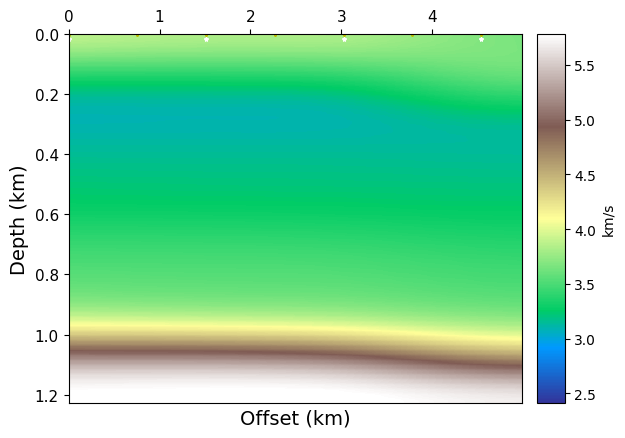

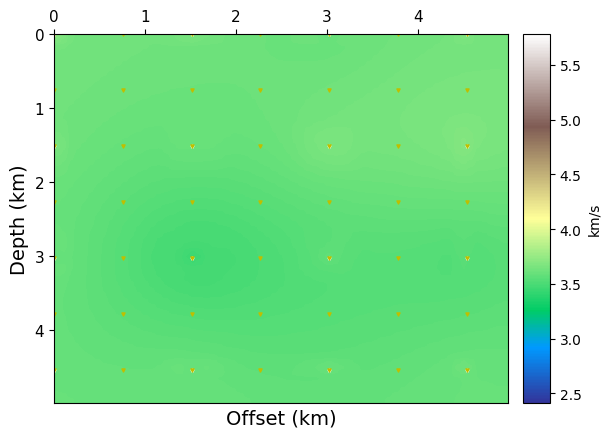

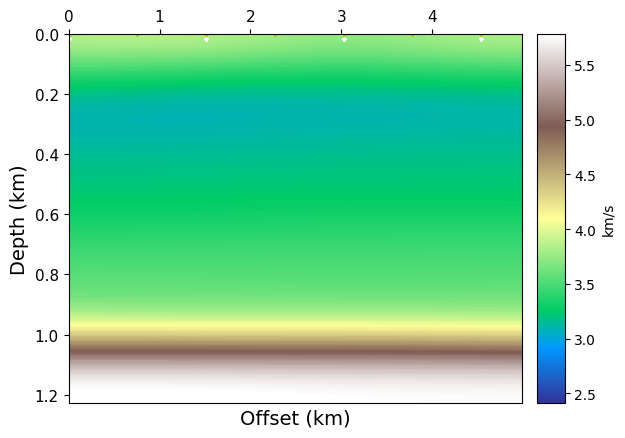

In [7]:
# Save model
torch.save({
        'tau_model_state_dict': tau_model.state_dict(),
        'v_model_state_dict': v_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Prediction
pde_loader, ic = create_dataloader3dwell([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048, fast_loader=True, perm_id=ipermute)
v_pred = evaluate_velocity3d(v_model, pde_loader, X.size, batch_size=2048, device=device)

tau_pred = evaluate_tau3d(tau_model, pde_loader, X.size, batch_size=2048, device=device)

v_pred = v_pred.detach().cpu().numpy()
tau_pred = tau_pred.detach().cpu().numpy()

# ZX plane after
plot_section(v_pred.reshape(X.shape)[:,10,:,i], 'v_pred_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

# XY plane
plot_section(v_pred.reshape(X.shape)[5,:,:,i], 'v_pred_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Y[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Y[:,:,:,i].reshape(-1)[id_rec])

# ZY plane
plot_section(v_pred.reshape(X.shape)[:,:,10,i], 'v_pred_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=Y[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

2.2670453999999998
1.5113636


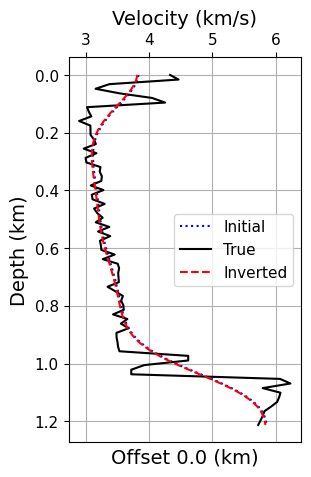

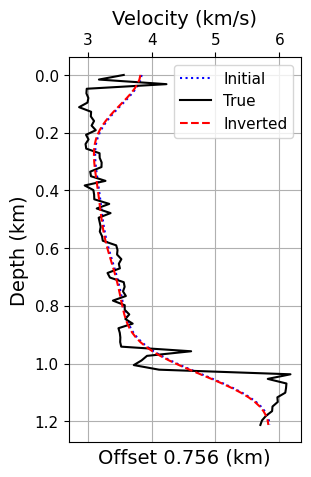

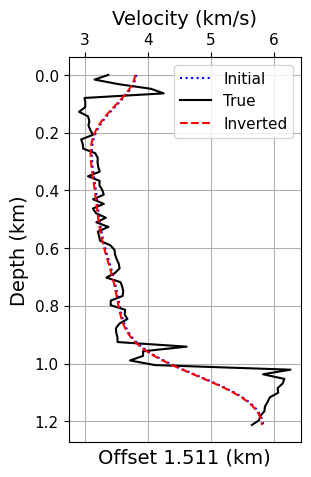

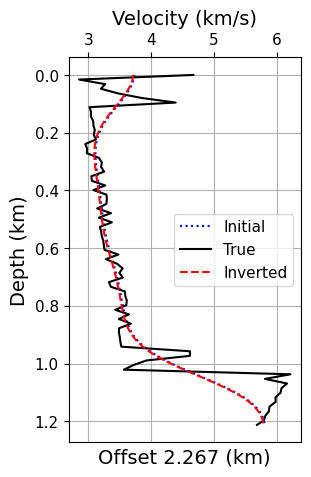

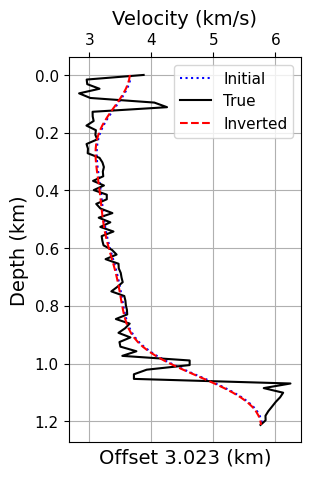

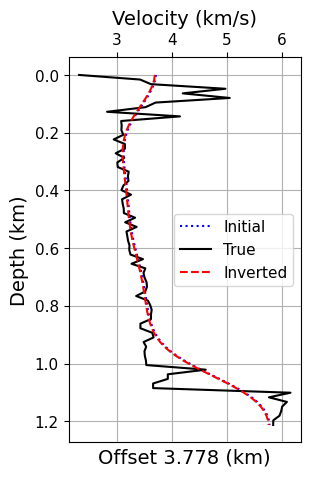

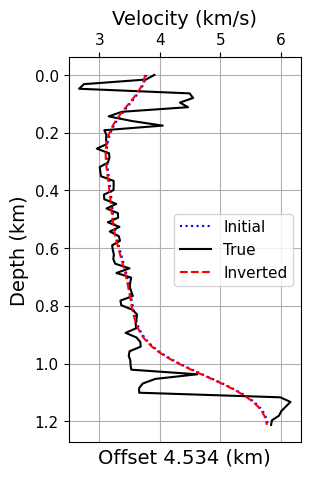

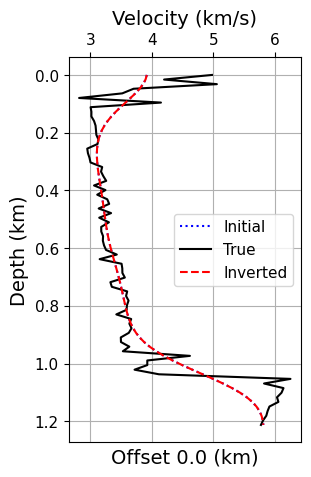

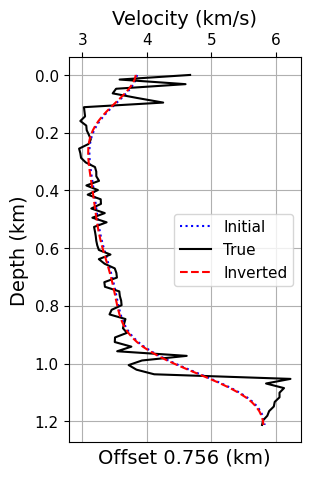

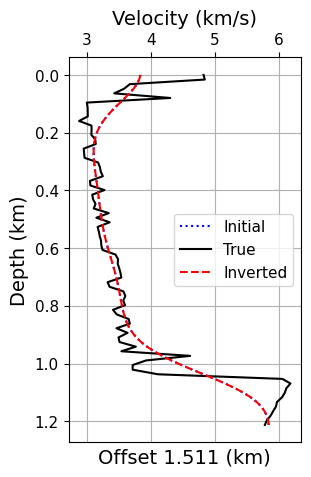

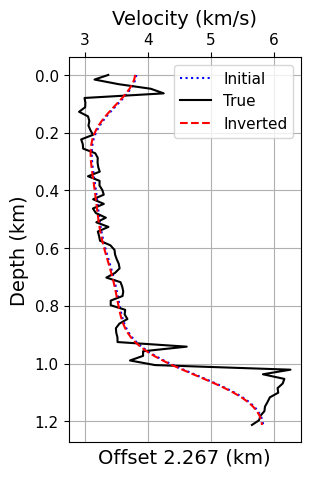

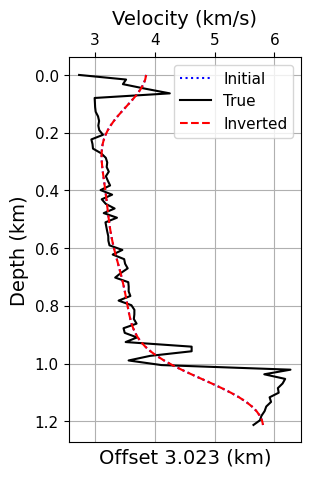

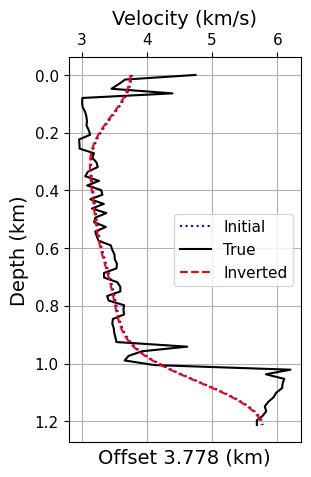

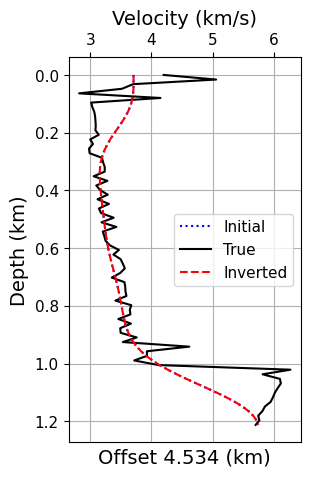

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.


In [8]:
print(y[30])
for i in range(len(x)):
    if i%10==0:
        plot_trace(v_well.cpu().numpy()[:,:,30], vel3d[:,:,30], v_pred.reshape(X.shape)[:,:,30,0], i, x, z, 
                   fig_name='trace_x_'+str(round(x[i], 2))+'.pdf', save_dir=wandb_dir)
        
print(x[20])
for i in range(len(y)):
    if i%10==0:
        plot_trace(v_well.cpu().numpy()[:,20,:], vel3d[:,20,:], v_pred.reshape(X.shape)[:,20,:,0], i, x, z, 
                   fig_name='trace_y_'+str(round(y[i], 2))+'.pdf', save_dir=wandb_dir)

In [ ]:
# XY plane
i=45
plot_depth(v_init.reshape(X.shape)[i,:,:,0], 'v_init_xy_z_'+str(round(z[i], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou])

# XY plane
plot_depth(v_pred.reshape(X.shape)[i,:,:,0], 'v_pred_xy_z_'+str(round(z[i], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou])

# XY plane
plot_depth(vel3d[i,:,:], 'v_data_xy_z_'+str(round(z[i], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou])

j=30

# ZX plane
plot_section(vel3d[:,j,:], 'v_data_zx_y_'+str(round(y[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou])

# ZX plane
i=0
plot_section(v_pred.reshape(X.shape)[:,j,:,i], 'v_pred_zx_y_'+str(round(y[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou])

# ZX plane
plot_section(v_init.reshape(X.shape)[:,j,:,0], 'v_init_zx_y_'+str(round(y[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou])

j=50

# ZY plane
plot_section(vel3d[:,:,j], 'v_data_zy_x_'+str(round(x[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou])

# ZY plane
i=0
plot_section(v_pred.reshape(X.shape)[:,:,j,i], 'v_pred_zy_x_'+str(round(x[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou])

# ZY plane
plot_section(v_init.reshape(X.shape)[:,:,j,0], 'v_init_zy_x_'+str(round(x[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou])

## Gathers

### Acoustic

In [ ]:
import torch
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'cpu')

x_fine = np.linspace(xmin, xmax, 10*len(x))
z_fine = np.linspace(zmin, zmax, 25*len(z)) 

f = interpolate.interp2d(x, z, vel3d[:,0,:], kind='cubic')
v_data = 1e3*torch.from_numpy(f(x_fine, z_fine)).float().to(device)

f = interpolate.interp2d(x, z, v_well[:,0,:].cpu().numpy(), kind='cubic')
v_true = 1e3*torch.from_numpy(f(x_fine, z_fine)).float().to(device)

f = interpolate.interp2d(x, z, v_pred.reshape(X.shape)[:,0,:,0], kind='cubic')
v_pinn = 1e3*torch.from_numpy(f(x_fine, z_fine)).float().to(device)

f = interpolate.interp2d(x, z, v_init.reshape(X.shape)[:,0,:,0], kind='cubic')
v_nini = 1e3*torch.from_numpy(f(x_fine, z_fine)).float().to(device)

dw_nz = v_data.shape[0]
dw_nx = v_data.shape[1]
dw_dx = 4.0

dw_ns = 55

dw_sps = 1
dw_ds = 40  # 20 * 4m = 80m
first_source = 10  # 10 * 4m = 40m
source_depth = 2  # 2 * 4m = 8m

dw_rps = 384
dw_dr = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 2  # 2 * 4m = 8m

dw_fr = 25
dw_nt = 250
dw_dt = 0.004
peak_time = 1.5 / dw_fr

# source_locations
source_locations = torch.zeros(dw_ns, dw_sps, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = (torch.arange(dw_ns) * dw_ds +
                             first_source)

# receiver_locations
receiver_locations = torch.zeros(dw_ns, dw_rps, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    (torch.arange(dw_rps) * dw_dr +
     first_receiver)
    .repeat(dw_ns, 1)
)

# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(dw_fr, dw_nt, dw_dt, peak_time)
    .repeat(dw_ns, dw_sps, 1)
    .to(device)
)

out_data = scalar(v_data, dw_dx, dw_dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=8,
             pml_freq=dw_fr)

out_true = scalar(v_true, dw_dx, dw_dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=8,
             pml_freq=dw_fr)

out_pred = scalar(v_pinn, dw_dx, dw_dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=8,
             pml_freq=dw_fr)

out_init = scalar(v_nini, dw_dx, dw_dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=8,
             pml_freq=dw_fr)

shot18_data = out_data[-1][18].cpu().T

shot18_true = out_true[-1][18].cpu().T

shot18_pred = out_pred[-1][18].cpu().T

shot18_init = out_init[-1][18].cpu().T

In [ ]:
# vmin, vmax = -0.0031, 0.0049

# plt.figure()
# plt.imshow(shot18_data[:,122:260].cpu(), aspect='auto',
#              cmap='gray', vmin=vmin, vmax=vmax)
# plt.xlabel("Channel")
# plt.ylabel("Time Sample")
# plt.tight_layout()

# # plt.figure()
# # plt.imshow(torch.flipud(shot18_pred[:,122:]).cpu(), aspect='auto',
# #              cmap='gray', vmin=vmin, vmax=vmax)
# # plt.xlabel("Channel")
# # plt.ylabel("Time Sample")
# # plt.tight_layout()


# plt.figure()
# plt.imshow(shot18_pred[:,122:].cpu(), aspect='auto',
#              cmap='gray', vmin=vmin, vmax=vmax)
# plt.xlabel("Channel")
# plt.ylabel("Time Sample")
# plt.tight_layout()


# plt.figure()
# plt.imshow(torch.fliplr(shot18_pred.cpu())[:,:262], aspect='auto',
#              cmap='gray', vmin=vmin, vmax=vmax)
# plt.xlabel("Channel")
# plt.ylabel("Time Sample")
# plt.tight_layout()

In [ ]:
vmin, vmax = -0.0031, 0.0049

combined = torch.cat((
    shot18_init[:,:122].cpu(),
    shot18_data[:,122:(2*122)].cpu(),
    torch.fliplr(shot18_init.cpu())[:,(shot18_pred.shape[1]-2*122):(shot18_pred.shape[1]-122)]
), 1)
plt.figure()
plt.imshow(combined, vmin=vmin, vmax=vmax, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Channels')
plt.ylabel('Time')
plt.savefig(wandb_dir+'/gathers_init.pdf')

combined = torch.cat((
    shot18_pred[:,:122].cpu(),
    shot18_data[:,122:(2*122)].cpu(),
    torch.fliplr(shot18_pred.cpu())[:,(shot18_pred.shape[1]-2*122):(shot18_pred.shape[1]-122)]
), 1)
plt.figure()
plt.imshow(combined, vmin=vmin, vmax=vmax, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Channels')
plt.ylabel('Time')
plt.savefig(wandb_dir+'/gathers_pred.pdf')

combined = torch.cat((
    shot18_true[:,:122].cpu(),
    shot18_data[:,122:(2*122)].cpu(),
    torch.fliplr(shot18_true.cpu())[:,(shot18_pred.shape[1]-2*122):(shot18_pred.shape[1]-122)]
), 1)
plt.figure()
plt.imshow(combined, vmin=vmin, vmax=vmax, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Channels')
plt.ylabel('Time')
plt.savefig(wandb_dir+'/gathers_true.pdf')

### Elastic

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import deepwave
# from deepwave import scalar

# device = torch.device('cuda' if torch.cuda.is_available()
#                       else 'cpu')

# x_fine = np.linspace(xmin, xmax, 10*len(x))
# z_fine = np.linspace(zmin, zmax, 25*len(z)) 
# f = interpolate.interp2d(x, z, vel3d[:,0,:], kind='cubic')
# v_data = 1e3*torch.from_numpy(f(x_fine, z_fine)).float().to(device)

# dw_nz = v_data.shape[0]
# dw_nx = v_data.shape[1]
# dw_dx = 4.0

# dw_ns = 55

# dw_sps = 1
# dw_ds = 40  # 20 * 4m = 80m
# first_source = 10  # 10 * 4m = 40m
# source_depth = 2  # 2 * 4m = 8m

# dw_rps = 384
# dw_dr = 6  # 6 * 4m = 24m
# first_receiver = 0  # 0 * 4m = 0m
# receiver_depth = 2  # 2 * 4m = 8m

# dw_fr = 25
# dw_nt = 250
# dw_dt = 0.004
# peak_time = 1.5 / dw_fr

# # source_locations
# source_locations = torch.zeros(dw_ns, dw_sps, 2,
#                                dtype=torch.long, device=device)
# source_locations[..., 1] = source_depth
# source_locations[:, 0, 0] = (torch.arange(dw_ns) * dw_ds +
#                              first_source)

# # receiver_locations
# receiver_locations = torch.zeros(dw_ns, dw_rps, 2,
#                                  dtype=torch.long, device=device)
# receiver_locations[..., 1] = receiver_depth
# receiver_locations[:, :, 0] = (
#     (torch.arange(dw_rps) * dw_dr +
#      first_receiver)
#     .repeat(dw_ns, 1)
# )

# # source_amplitudes
# source_amplitudes = (
#     deepwave.wavelets.ricker(dw_fr, dw_nt, dw_dt, peak_time)
#     .repeat(dw_ns, dw_sps, 1)
#     .to(device)
# )

# observed_data = elastic(
#     *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_true, vs_true,
#                                                rho_true),
#     dx, dt,
#     source_amplitudes_y=source_amplitudes,
#     source_locations_y=source_locations,
#     receiver_locations_y=receiver_locations,
#     pml_freq=freq,
# )[-2]

## Operator function

In [ ]:
class VelocityNetwork(torch.nn.Module):
    def __init__(self, base_model, v_well=1, X_well=None):
        
            super(VelocityNetwork, self).__init__()
            
            self.model = base_model
            self.v_well = v_well
            self.X_well = X_well
            
            if self.X_well is not None:
                self.x_well = X_well[:,0]
                self.y_well = X_well[:,1]
            
    def _well_operator(self, x):
        x_op, y_op = 1, 1
        
        for i in range(len(self.x_well)):
            x_op *= (x[:,0].view(-1,1) - self.x_well[i]) 
        for i in range(len(self.y_well)):
            y_op *= (x[:,1].view(-1,1) - self.y_well[i])
        
        return nn.Tanh()((x_op + y_op))

        # returntorch.exp(-0.05*x[:,2]).view(-1,1)

    def forward(self,x,v_well=1):
        
        if self.X_well is not None:
            x = 4self._well_operator(x)
        else:
            x = self.model(x)
        return x
    
def evaluate_velocity3d(v_model, grid_loader, num_pts, batch_size, device):
    v_model.eval()
    
    # Prepare input
    with torch.no_grad():
        V = torch.empty(num_pts, device=device)
        for i, X in enumerate(grid_loader):

            # Compute v
            # print(X[0].shape)
            batch_end = (i+1)*batch_size if (i+1)*batch_size<num_pts else i*batch_size + X[0].shape[0]
            # print(i, batch_end,  v_model(X[0], X[-1]).view(-1).shape)
            V[i*batch_size:batch_end] = v_model(X[0], X[-1]).view(-1)

    return V
    
model = VelocityNetwork(base_model, v_well, X_well)
model.to(device)

v_try = evaluate_velocity3d(model, pde_loader, X.size, batch_size=2048, device=device)

In [ ]:
# ZX plane after
plot_section(v_try.detach().cpu().reshape(X.shape)[:,20,:,i], 'v_well_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

In [ ]:
# ZX plane after
plot_section(v_try.detach().cpu().reshape(X.shape)[:,20,:,i], 'v_init_tanh1e-3_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

In [ ]:
# ZX plane after
plot_section(v_try.detach().cpu().reshape(X.shape)[:,20,:,i], 'v_init_tanh_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])